# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([ 0.03627577, -0.02392764,  0.00057116,  0.02286505]),
  0,
  array([ 0.03579721, -0.21905778,  0.00102846,  0.31572813]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.5268027337982506 -2.79364965838285


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

In [18]:
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
batch = sample(ListArr=rated_mem, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
# rates = np.array([each[5] for each in batch])

In [19]:
states.shape, states.dtype, actions.shape, actions.dtype, next_states.shape, next_states.dtype, \
rewards.shape, rewards.dtype, dones.shape, dones.dtype, rates.shape, rates.dtype

((100, 4),
 dtype('float64'),
 (100,),
 dtype('int64'),
 (100, 4),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100000,),
 dtype('O'))

In [20]:
rates

array([0.056, 0.056, 0.056, ..., -1, -1, -1], dtype=object)

In [21]:
dones

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            allrates = np.array(memory.buffer)[:, 5]
            rated_mem = np.array(memory.buffer)[allrates >= (max(allrates)*0.2)]
            batch = sample(ListArr=rated_mem, batch_size=batch_size)
            #mem = np.array(memory.buffer)
            #batch = sample(ListArr=mem, batch_size=batch_size)
            #batch = sample(ListArr=memory.buffer, batch_size=batch_size)
            #batch = memory.sample(batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0 rate:0.0400 loss:1.0746 exploreP:0.9980
Episode:1 meanR:31.5000 R:43.0 rate:0.0860 loss:1.1906 exploreP:0.9938
Episode:2 meanR:34.3333 R:40.0 rate:0.0800 loss:1.3368 exploreP:0.9899
Episode:3 meanR:36.7500 R:44.0 rate:0.0880 loss:1.4294 exploreP:0.9856
Episode:4 meanR:32.2000 R:14.0 rate:0.0280 loss:1.4962 exploreP:0.9842
Episode:5 meanR:31.3333 R:27.0 rate:0.0540 loss:1.5345 exploreP:0.9816
Episode:6 meanR:29.1429 R:16.0 rate:0.0320 loss:1.5397 exploreP:0.9800
Episode:7 meanR:28.5000 R:24.0 rate:0.0480 loss:1.5052 exploreP:0.9777
Episode:8 meanR:26.5556 R:11.0 rate:0.0220 loss:1.4323 exploreP:0.9766
Episode:9 meanR:27.7000 R:38.0 rate:0.0760 loss:1.4882 exploreP:0.9730
Episode:10 meanR:27.0909 R:21.0 rate:0.0420 loss:1.4894 exploreP:0.9709
Episode:11 meanR:26.2500 R:17.0 rate:0.0340 loss:1.4619 exploreP:0.9693
Episode:12 meanR:25.3846 R:15.0 rate:0.0300 loss:1.5265 exploreP:0.9679
Episode:13 meanR:24.6429 R:15.0 rate:0.0300 loss:1.5823 exploreP:0.9664
Ep

Episode:113 meanR:22.0000 R:14.0 rate:0.0280 loss:71.0945 exploreP:0.7776
Episode:114 meanR:21.9700 R:10.0 rate:0.0200 loss:39.3250 exploreP:0.7768
Episode:115 meanR:21.9100 R:15.0 rate:0.0300 loss:43.5094 exploreP:0.7756
Episode:116 meanR:21.9000 R:16.0 rate:0.0320 loss:44.7160 exploreP:0.7744
Episode:117 meanR:21.6500 R:18.0 rate:0.0360 loss:48.6355 exploreP:0.7730
Episode:118 meanR:21.5800 R:11.0 rate:0.0220 loss:48.1457 exploreP:0.7722
Episode:119 meanR:21.6900 R:34.0 rate:0.0680 loss:42.8742 exploreP:0.7696
Episode:120 meanR:21.3000 R:16.0 rate:0.0320 loss:57.6774 exploreP:0.7684
Episode:121 meanR:21.2700 R:12.0 rate:0.0240 loss:41.3575 exploreP:0.7675
Episode:122 meanR:21.1400 R:13.0 rate:0.0260 loss:58.4111 exploreP:0.7665
Episode:123 meanR:21.1400 R:26.0 rate:0.0520 loss:60.1071 exploreP:0.7645
Episode:124 meanR:21.1200 R:15.0 rate:0.0300 loss:39.1479 exploreP:0.7634
Episode:125 meanR:20.7600 R:18.0 rate:0.0360 loss:41.8508 exploreP:0.7621
Episode:126 meanR:20.7400 R:13.0 rate:

Episode:224 meanR:37.2000 R:72.0 rate:0.1440 loss:37.8748 exploreP:0.5294
Episode:225 meanR:37.5700 R:55.0 rate:0.1100 loss:34.9659 exploreP:0.5265
Episode:226 meanR:38.1800 R:74.0 rate:0.1480 loss:41.2187 exploreP:0.5227
Episode:227 meanR:38.4500 R:39.0 rate:0.0780 loss:35.7512 exploreP:0.5207
Episode:228 meanR:38.7700 R:53.0 rate:0.1060 loss:39.9025 exploreP:0.5180
Episode:229 meanR:38.9000 R:60.0 rate:0.1200 loss:43.9062 exploreP:0.5150
Episode:230 meanR:39.2200 R:41.0 rate:0.0820 loss:43.6881 exploreP:0.5129
Episode:231 meanR:39.6100 R:58.0 rate:0.1160 loss:42.7890 exploreP:0.5100
Episode:232 meanR:39.6300 R:30.0 rate:0.0600 loss:42.6608 exploreP:0.5085
Episode:233 meanR:40.3500 R:108.0 rate:0.2160 loss:46.4939 exploreP:0.5031
Episode:234 meanR:40.6200 R:42.0 rate:0.0840 loss:42.6616 exploreP:0.5011
Episode:235 meanR:41.6700 R:136.0 rate:0.2720 loss:46.0250 exploreP:0.4944
Episode:236 meanR:41.9800 R:55.0 rate:0.1100 loss:53.7461 exploreP:0.4918
Episode:237 meanR:42.4600 R:65.0 rat

Episode:334 meanR:200.8700 R:469.0 rate:0.9380 loss:22.7159 exploreP:0.0759
Episode:335 meanR:203.4100 R:390.0 rate:0.7800 loss:18.6878 exploreP:0.0734
Episode:336 meanR:207.2400 R:438.0 rate:0.8760 loss:22.2125 exploreP:0.0706
Episode:337 meanR:210.3300 R:374.0 rate:0.7480 loss:24.5704 exploreP:0.0684
Episode:338 meanR:212.5800 R:340.0 rate:0.6800 loss:23.7972 exploreP:0.0665
Episode:339 meanR:215.5600 R:337.0 rate:0.6740 loss:24.2481 exploreP:0.0646
Episode:340 meanR:218.6400 R:346.0 rate:0.6920 loss:21.0750 exploreP:0.0627
Episode:341 meanR:220.7800 R:313.0 rate:0.6260 loss:25.7669 exploreP:0.0611
Episode:342 meanR:223.9800 R:353.0 rate:0.7060 loss:22.0307 exploreP:0.0593
Episode:343 meanR:226.2700 R:338.0 rate:0.6760 loss:24.5316 exploreP:0.0577
Episode:344 meanR:229.4500 R:361.0 rate:0.7220 loss:24.3913 exploreP:0.0560
Episode:345 meanR:231.6600 R:336.0 rate:0.6720 loss:22.0253 exploreP:0.0545
Episode:346 meanR:234.2100 R:282.0 rate:0.5640 loss:25.3014 exploreP:0.0533
Episode:347 

Episode:443 meanR:358.0700 R:269.0 rate:0.5380 loss:3.9018 exploreP:0.0113
Episode:444 meanR:357.3500 R:289.0 rate:0.5780 loss:5.3490 exploreP:0.0113
Episode:445 meanR:358.9900 R:500.0 rate:1.0000 loss:3.5359 exploreP:0.0112
Episode:446 meanR:359.1600 R:299.0 rate:0.5980 loss:5.5375 exploreP:0.0112
Episode:447 meanR:359.2800 R:368.0 rate:0.7360 loss:5.8241 exploreP:0.0111
Episode:448 meanR:359.5700 R:347.0 rate:0.6940 loss:5.6850 exploreP:0.0111
Episode:449 meanR:360.0900 R:435.0 rate:0.8700 loss:4.8842 exploreP:0.0111
Episode:450 meanR:359.6100 R:310.0 rate:0.6200 loss:4.9554 exploreP:0.0110
Episode:451 meanR:361.3200 R:500.0 rate:1.0000 loss:4.3705 exploreP:0.0110
Episode:452 meanR:361.7000 R:368.0 rate:0.7360 loss:3.4490 exploreP:0.0109
Episode:453 meanR:361.1800 R:294.0 rate:0.5880 loss:4.6133 exploreP:0.0109
Episode:454 meanR:361.5200 R:323.0 rate:0.6460 loss:3.6791 exploreP:0.0109
Episode:455 meanR:362.7200 R:417.0 rate:0.8340 loss:4.4685 exploreP:0.0109
Episode:456 meanR:362.020

Episode:553 meanR:374.8600 R:500.0 rate:1.0000 loss:3.9036 exploreP:0.0100
Episode:554 meanR:376.5700 R:494.0 rate:0.9880 loss:3.0027 exploreP:0.0100
Episode:555 meanR:376.0000 R:360.0 rate:0.7200 loss:3.6204 exploreP:0.0100
Episode:556 meanR:376.9900 R:333.0 rate:0.6660 loss:3.3993 exploreP:0.0100
Episode:557 meanR:378.3300 R:500.0 rate:1.0000 loss:3.0046 exploreP:0.0100
Episode:558 meanR:379.9700 R:500.0 rate:1.0000 loss:2.9419 exploreP:0.0100
Episode:559 meanR:378.6300 R:366.0 rate:0.7320 loss:2.9142 exploreP:0.0100
Episode:560 meanR:376.8500 R:278.0 rate:0.5560 loss:2.8469 exploreP:0.0100
Episode:561 meanR:376.9900 R:457.0 rate:0.9140 loss:3.2923 exploreP:0.0100
Episode:562 meanR:376.2700 R:406.0 rate:0.8120 loss:2.5615 exploreP:0.0100
Episode:563 meanR:376.2700 R:252.0 rate:0.5040 loss:4.4205 exploreP:0.0100
Episode:564 meanR:376.4000 R:306.0 rate:0.6120 loss:2.9456 exploreP:0.0100
Episode:565 meanR:374.4000 R:300.0 rate:0.6000 loss:1.7660 exploreP:0.0100
Episode:566 meanR:375.370

Episode:663 meanR:78.8400 R:8.0 rate:0.0160 loss:937.3717 exploreP:0.0100
Episode:664 meanR:75.8800 R:10.0 rate:0.0200 loss:4326.5596 exploreP:0.0100
Episode:665 meanR:72.9600 R:8.0 rate:0.0160 loss:2266.9880 exploreP:0.0100
Episode:666 meanR:68.1000 R:10.0 rate:0.0200 loss:5106.5063 exploreP:0.0100
Episode:667 meanR:64.8600 R:10.0 rate:0.0200 loss:3698.2329 exploreP:0.0100
Episode:668 meanR:62.4800 R:10.0 rate:0.0200 loss:390.6494 exploreP:0.0100
Episode:669 meanR:58.6200 R:10.0 rate:0.0200 loss:4927.5039 exploreP:0.0100
Episode:670 meanR:57.0100 R:9.0 rate:0.0180 loss:2770.1675 exploreP:0.0100
Episode:671 meanR:54.6400 R:9.0 rate:0.0180 loss:7044.0859 exploreP:0.0100
Episode:672 meanR:52.4500 R:10.0 rate:0.0200 loss:3607.1614 exploreP:0.0100
Episode:673 meanR:49.2000 R:9.0 rate:0.0180 loss:3831.0161 exploreP:0.0100
Episode:674 meanR:45.9900 R:10.0 rate:0.0200 loss:5247.7485 exploreP:0.0100
Episode:675 meanR:44.1600 R:9.0 rate:0.0180 loss:2243.1470 exploreP:0.0100
Episode:676 meanR:41

Episode:772 meanR:9.4500 R:11.0 rate:0.0220 loss:42624.9570 exploreP:0.0100
Episode:773 meanR:9.4600 R:10.0 rate:0.0200 loss:4003.9954 exploreP:0.0100
Episode:774 meanR:9.4400 R:8.0 rate:0.0160 loss:25279.7930 exploreP:0.0100
Episode:775 meanR:9.4600 R:11.0 rate:0.0220 loss:59342.9531 exploreP:0.0100
Episode:776 meanR:9.4600 R:10.0 rate:0.0200 loss:83103.8047 exploreP:0.0100
Episode:777 meanR:9.4700 R:9.0 rate:0.0180 loss:30432.8965 exploreP:0.0100
Episode:778 meanR:9.4700 R:9.0 rate:0.0180 loss:28886.3457 exploreP:0.0100
Episode:779 meanR:9.4700 R:9.0 rate:0.0180 loss:44082.1875 exploreP:0.0100
Episode:780 meanR:9.4700 R:9.0 rate:0.0180 loss:49083.7656 exploreP:0.0100
Episode:781 meanR:9.4600 R:9.0 rate:0.0180 loss:16600.3730 exploreP:0.0100
Episode:782 meanR:9.4400 R:8.0 rate:0.0160 loss:28582.4238 exploreP:0.0100
Episode:783 meanR:9.4600 R:11.0 rate:0.0220 loss:28024.9570 exploreP:0.0100
Episode:784 meanR:9.4700 R:10.0 rate:0.0200 loss:97490.4688 exploreP:0.0100
Episode:785 meanR:9.

Episode:881 meanR:9.5200 R:10.0 rate:0.0200 loss:221768.6719 exploreP:0.0100
Episode:882 meanR:9.5400 R:10.0 rate:0.0200 loss:280240.6875 exploreP:0.0100
Episode:883 meanR:9.5300 R:10.0 rate:0.0200 loss:249761.8750 exploreP:0.0100
Episode:884 meanR:9.5100 R:8.0 rate:0.0160 loss:310031.6250 exploreP:0.0100
Episode:885 meanR:9.5000 R:9.0 rate:0.0180 loss:45587.8828 exploreP:0.0100
Episode:886 meanR:9.5200 R:12.0 rate:0.0240 loss:336548.0312 exploreP:0.0100
Episode:887 meanR:9.5000 R:8.0 rate:0.0160 loss:24887.3770 exploreP:0.0100
Episode:888 meanR:9.5000 R:10.0 rate:0.0200 loss:49902.1133 exploreP:0.0100
Episode:889 meanR:9.5000 R:10.0 rate:0.0200 loss:171722.0625 exploreP:0.0100
Episode:890 meanR:9.5100 R:10.0 rate:0.0200 loss:145271.7969 exploreP:0.0100
Episode:891 meanR:9.5300 R:11.0 rate:0.0220 loss:450550.1875 exploreP:0.0100
Episode:892 meanR:9.5100 R:8.0 rate:0.0160 loss:433695.0625 exploreP:0.0100
Episode:893 meanR:9.5100 R:10.0 rate:0.0200 loss:276693.6875 exploreP:0.0100
Episod

Episode:989 meanR:9.4300 R:9.0 rate:0.0180 loss:1193915.1250 exploreP:0.0100
Episode:990 meanR:9.4300 R:10.0 rate:0.0200 loss:139064.5625 exploreP:0.0100
Episode:991 meanR:9.4100 R:9.0 rate:0.0180 loss:883438.6875 exploreP:0.0100
Episode:992 meanR:9.4200 R:9.0 rate:0.0180 loss:1350410.6250 exploreP:0.0100
Episode:993 meanR:9.4200 R:10.0 rate:0.0200 loss:748018.0625 exploreP:0.0100
Episode:994 meanR:9.4000 R:9.0 rate:0.0180 loss:1574113.1250 exploreP:0.0100
Episode:995 meanR:9.4100 R:10.0 rate:0.0200 loss:714938.3750 exploreP:0.0100
Episode:996 meanR:9.4100 R:10.0 rate:0.0200 loss:804685.3750 exploreP:0.0100
Episode:997 meanR:9.4000 R:9.0 rate:0.0180 loss:468986.3438 exploreP:0.0100
Episode:998 meanR:9.4100 R:9.0 rate:0.0180 loss:864189.2500 exploreP:0.0100
Episode:999 meanR:9.4000 R:8.0 rate:0.0160 loss:1828215.5000 exploreP:0.0100
Episode:1000 meanR:9.4000 R:10.0 rate:0.0200 loss:770214.6250 exploreP:0.0100
Episode:1001 meanR:9.4000 R:10.0 rate:0.0200 loss:158502.1406 exploreP:0.0100


Episode:1095 meanR:9.4800 R:10.0 rate:0.0200 loss:2178316.5000 exploreP:0.0100
Episode:1096 meanR:9.4700 R:9.0 rate:0.0180 loss:2557980.5000 exploreP:0.0100
Episode:1097 meanR:9.4700 R:9.0 rate:0.0180 loss:218890.2188 exploreP:0.0100
Episode:1098 meanR:9.4800 R:10.0 rate:0.0200 loss:1191873.8750 exploreP:0.0100
Episode:1099 meanR:9.5000 R:10.0 rate:0.0200 loss:2199075.7500 exploreP:0.0100
Episode:1100 meanR:9.4800 R:8.0 rate:0.0160 loss:1360139.3750 exploreP:0.0100
Episode:1101 meanR:9.4900 R:11.0 rate:0.0220 loss:231706.2969 exploreP:0.0100
Episode:1102 meanR:9.4800 R:8.0 rate:0.0160 loss:7528287.0000 exploreP:0.0100
Episode:1103 meanR:9.4700 R:9.0 rate:0.0180 loss:2160985.0000 exploreP:0.0100
Episode:1104 meanR:9.4700 R:9.0 rate:0.0180 loss:2552109.5000 exploreP:0.0100
Episode:1105 meanR:9.4700 R:9.0 rate:0.0180 loss:1596440.2500 exploreP:0.0100
Episode:1106 meanR:9.4600 R:10.0 rate:0.0200 loss:1390005.8750 exploreP:0.0100
Episode:1107 meanR:9.4600 R:10.0 rate:0.0200 loss:2065690.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

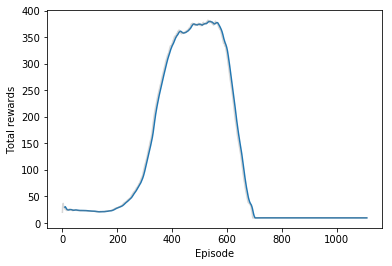

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

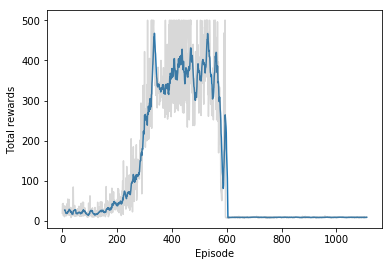

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

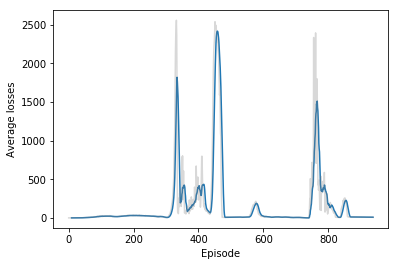

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.